In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/traveling-salesman-problem'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traveling-salesman-problem/medium.csv
/kaggle/input/traveling-salesman-problem/tiny.csv
/kaggle/input/traveling-salesman-problem/large.csv
/kaggle/input/traveling-salesman-problem/small.csv


> Visualize

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

#  **Khởi tạo quần thể**

In [5]:
def distance_matrix(cities):
    distance_matrix = []
    for i in range(len(cities)):
        distance_vector = []
        for j in range(len(cities)):
            # Truy cập giá trị theo nhãn hàng và tên cột
            distance = ((cities.loc[i, 'x'] - cities.loc[j, 'x'])**2 + (cities.loc[i, 'y'] - cities.loc[j, 'y'])**2)**0.5
            distance_vector.append(distance)
        distance_matrix.append(distance_vector)
    return distance_matrix


# hàm thích nghi trong bài toán này là tổng khoảng cách giữa các thành phố trên lộ trình (cá thể)
def fitness(individual, distance_mat ):
    total_distance = 0  
    for i in range(len(individual) - 1):
        cityA = int(individual[i])
        cityB = int(individual[i + 1]) 
        total_distance += distance_mat[cityA][cityB] 

    # Quay lại thành phố đầu tiên
    cityA = int(individual[0]) - 1
    total_distance += distance_mat[cityA][int(individual[-1]) - 1] 

    return total_distance


In [6]:
def readData(path):
    cities = pd.read_csv(path)
    cities.columns = ["x","y"]
    distance_mat = distance_matrix(cities)
    return cities, distance_mat

In [7]:
import numpy as np
import math
import random
def initialize_population(cities):
    population = []
    num_cities = len(cities)
    pop_size = 100
    for _ in range(pop_size):
        individual = list(range(num_cities))
        random.shuffle(individual)
        
        distance = fitness(individual, distance_mat = distance_matrix(cities))
        population.append([distance, individual])
    
    return population

# **Lai tạo**
Kết hợp hai cá thể (chromosomes) từ quần thể hiện tại để tạo ra con cháu mới, mang đặc tính từ cả hai cá thể cha mẹ với mục tiêu tạo ra những cá thể mới với tiềm năng có giá trị thích nghi (fitness) tốt hơn, góp phần vào việc tối ưu hóa lời giải trong quá trình tiến hóa.

> Lai ghép một điểm cắt

In [8]:
def singlePointCrossover(father1, father2, lenCities=51):
    point = random.randint(0, lenCities - 1)
    
    new_invi1 = father2[0:point]
    for invi in father1:
        if invi not in new_invi1:
            new_invi1.append(invi)
            
    new_invi2 = father1[0:point]
    for invi in father2:
        if invi not in new_invi2:
            new_invi2.append(invi)
            
    return new_invi1, new_invi2

> Lai ghép 2 điểm cắt

In [9]:
def multiPointCrossover(father1, father2, lenCities=51):
    points = sorted(random.sample(father1, 2))
    point1 = int(points[0]) - 1
    point2 = int(points[1]) - 1
    
    new_invi1 = father2[point1:point2]
    c1 = 0
    c2 = 0
    for invi in father1:
        if invi not in new_invi1:
            c1 += 1
            if c1 <= point1:
                new_invi1.append(invi)
            else:
                new_invi1.insert(c2, invi)
                c2 += 1
            
            
    new_invi2 = father1[point1:point2]
    c1 = 0
    c2 = 0
    for invi in father2:
        if invi not in new_invi2:
            c1 += 1
            if c1 <= point1:
                new_invi2.append(invi)
            else:
                new_invi2.insert(c2, invi)
                c2 += 1
                
    return new_invi1, new_invi2

> Lai ghép vòng

In [10]:
def cycleCrossover(father1, father2, lenCities=51):
    father1 = [int(s) for s in father1]
    father2 = [int(s) for s in father2]
    
    points = sorted(random.sample([i for i in range(lenCities)], 2))
    p1 = 0#p1 = int(points[0])
    p2 = 1#int(points[1])
    
    # inv1
    inv1 = list(np.zeros(lenCities, dtype=np.int8))
    inv1[p1] = father1[p1]
    s1 = p1
    count = 0
    while father2[s1] != father1[p1] and count != lenCities:
        count += 1
        s1 = father2[s1] - 1
        inv1[s1] = father1[s1]
    
    for city_i in father2:
        if city_i not in inv1:
            for i in range(lenCities):
                if inv1[i] == 0:
                    inv1[i] = city_i
                    break
    
    # inv2
    inv2 = list(np.zeros(lenCities, dtype=np.int8))
    inv2[p2] = father1[p2]
    s2 = p2
    count = 0
    while father2[s2] != father1[p2] and count != lenCities:
        count += 1
        s2 = father2[s2] - 1
        inv2[s2] = father1[s2]
    
    for city_i in father2:
        if city_i not in inv2:
            for i in range(lenCities):
                if inv2[i] == 0:
                    inv2[i] = city_i
                    break
    
    inv1 = [np.str_(s) for s in inv1]
    inv2 = [np.str_(s) for s in inv2]
    
    return inv1, inv2

In [11]:
import random

def pmx(parent1, parent2):
    size = len(parent1)
    child1, child2 = [-1]*size, [-1]*size

    # Choose crossover points
    cx_point1, cx_point2 = sorted(random.sample(range(size), 2))

    # Copy the segment from first parent to child
    child1[cx_point1:cx_point2] = parent1[cx_point1:cx_point2]
    child2[cx_point1:cx_point2] = parent2[cx_point1:cx_point2]

    def fill_child(child, parent):
        for ind in range(cx_point1, cx_point2):
            if parent[ind] not in child:
                pos = ind
                while cx_point1 <= pos < cx_point2:
                    pos = parent.index(child[pos])
                child[pos] = parent[ind]

    fill_child(child1, parent2)
    fill_child(child2, parent1)

    for ind in range(size):
        if child1[ind] == -1:
            child1[ind] = parent2[ind]
        if child2[ind] == -1:
            child2[ind] = parent1[ind]

    return child1, child2

# Đột biến
Chọn ngẫu nhiên 2 thành phố cho nhau rồi đổi chỗ

In [12]:
def mutation(father, lenCities=51):
    new_invi = father.copy()
    for _ in range(2):
        points = random.sample(new_invi, 2)
        temp = new_invi[int(points[0]) - 1]
        new_invi[int(points[0]) - 1] = new_invi[int(points[1]) - 1]
        new_invi[int(points[1]) - 1] = temp
        
    return new_invi

In [13]:
def tournaments(old_population, new_invivduals, population_size = 100):
    new_population = []
    k1 = 2
    k2 = 2
    
    # giữ lại k1 cá thể tốt nhất của quần thể cũ
    tmp1 = sorted(old_population)
    for i in range(k1):
        new_population.append(tmp1[i])
    
    # giữ lại k2 cá thể mới được sinh ra
    tmp2 = sorted(new_invivduals)
    for i in range(k2):
        new_population.append(tmp2[i])
        
    # lấy ngẫu nhiên k3 cá thể trong các cá thể còn lại
    tmp3 = tmp1[k1:] + tmp2[k2:]
    k3 = population_size - k1 - k2
    new_population = new_population + random.choices(tmp3, k=k3)
    
    return new_population


# HÀM GA

In [14]:
def GA(cities,
    population,
    lenCities=51,
    population_size=100,
    num_of_generations=500,
    crossover_rate=0.9,
    mutation_rate=0.1,
    crossover_func = singlePointCrossover,
    k=4
):
    elite = []  # Lưu lại cá thể tốt nhất trong mỗi thế hệ
    elite.append(sorted(population, key=lambda x: x[0])[0][0])  # Sắp xếp theo fitness
    distance_mat = distance_matrix(cities)
    for _ in range(num_of_generations):
        new_individuals = []
        
        # Sinh population_size cá thể mới
        n = int(population_size / 2)
        for _ in range(n):
            # Xảy ra quá trình lai ghép (crossover)
            if random.random() <= crossover_rate:
                # Chọn cá thể tốt nhất trong 'k' cá thể ngẫu nhiên làm father1
                father1 = sorted(random.choices(population, k=k), key=lambda x: x[0])[0][1]
                
                # Chọn cá thể tốt nhất trong 'k' cá thể ngẫu nhiên làm father2
                father2 = sorted(random.choices(population, k=k), key=lambda x: x[0])[0][1]
                
                # Thực hiện lai ghép 2 cá thể này
                inv1, inv2 = crossover_func(father1, father2)
                
                # Xảy ra quá trình đột biến (mutation)
                if random.random() <= mutation_rate:
                    inv1 = mutation(inv1, lenCities)
                    inv2 = mutation(inv2, lenCities)
            else:
                # Nếu không có lai ghép xảy ra, thì lấy ngẫu nhiên 2 cá thể trong quần thể cũ
                inv1 = random.choice(population)[1]
                inv2 = random.choice(population)[1]
            
            # Thêm cá thể mới vào danh sách
            new_individuals.append([fitness(inv1, distance_mat), inv1])
            new_individuals.append([fitness(inv2, distance_mat), inv2])
        
        # Thực hiện chọn lọc quần thể mới
        population = tournaments(population, new_individuals, population_size)
        
        # Lưu lại cá thể tốt nhất của thế hệ hiện tại
        elite.append(sorted(population, key=lambda x: x[0])[0][0])
    
    # Trả về quần thể sắp xếp và danh sách elite
    return sorted(population, key=lambda x: x[0]), elite


In [15]:
import timeit

In [16]:
def GA_with_SinglePointCrossover(cities):
    GA_with_singlePointCrossover= []
    minimum = 1e8
    singlePoint_pop, record_fitness = None, None
    sum_fitness = np.zeros(500)
    population = initialize_population(cities) 
    start = timeit.default_timer()

    for i in range(30):
        random.seed(i)
        # Khởi tạo quần thể đầu tiên
        pop, fitness_score = GA(cities = cities, population=population, crossover_func= singlePointCrossover, lenCities=len(cities))
        for j in range(500):
            sum_fitness[j] += fitness_score[j]
        if minimum > pop[0][0]:
            minimum = pop[0][0]
            singlePoint_pop, record_fitness = pop, fitness_score

        GA_with_singlePointCrossover.append([round(pop[0][0], 2), "map_" + str(i)])

    average_fitness_1 = [float(x)/30 for x in sum_fitness]
    singlePoint_time = round((timeit.default_timer() - start)/30, 2)
    return GA_with_singlePointCrossover, singlePoint_time, singlePoint_pop, record_fitness


In [31]:
def GA_with_MultiPointCrossover(cities):
    GA_with_multiPointCrossover = []
    minimum = 1e8
    multiPoint_pop, record_fitness_multiPoint = None, None
    sum_fitness = np.zeros(500)
    population = initialize_population(cities) 
    start = timeit.default_timer()

    for i in range(30):
        random.seed(i)
        # Khởi tạo quần thể đầu tiên
        pop, fitness_score = GA(cities=cities, population=population, crossover_func=multiPointCrossover, lenCities=len(cities))
        for j in range(500):
            sum_fitness[j] += fitness_score[j]
        if minimum > pop[0][0]:
            minimum = pop[0][0]
            multiPoint_pop, record_fitness_multiPoint = pop, fitness_score

        GA_with_multiPointCrossover.append([round(pop[0][0], 2), "map_" + str(i)])

    average_fitness_multiPoint = [float(x) / 30 for x in sum_fitness]
    multiPoint_time = round((timeit.default_timer() - start) / 30, 2)
    return GA_with_multiPointCrossover, multiPoint_time, multiPoint_pop, record_fitness_multiPoint


In [29]:
def GA_with_CycleCrossover(cities):
    GA_with_cycleCrossover = []
    minimum = 1e8
    cycle_pop, record_fitness_cycle = None, None
    sum_fitness = np.zeros(500)
    population = initialize_population(cities) 
    start = timeit.default_timer()

    for i in range(30):
        random.seed(i)
        # Khởi tạo quần thể đầu tiên
        pop, fitness_score = GA(cities=cities, population=population, crossover_func=cycleCrossover, lenCities=len(cities))
        for j in range(500):
            sum_fitness[j] += fitness_score[j]
        if minimum > pop[0][0]:
            minimum = pop[0][0]
            cycle_pop, record_fitness_cycle = pop, fitness_score

        GA_with_cycleCrossover.append([round(pop[0][0], 2), "map_" + str(i)])

    average_fitness_cycle = [float(x) / 30 for x in sum_fitness]
    cycle_time = round((timeit.default_timer() - start) / 30, 2)
    return GA_with_cycleCrossover, cycle_time, cycle_pop, record_fitness_cycle


In [32]:
def GA_with_PMX(cities):
    GA_with_pmx = []
    minimum = 1e8
    pmx_pop, record_fitness_pmx = None, None
    sum_fitness = np.zeros(500)
    population = initialize_population(cities) 
    start = timeit.default_timer()

    for i in range(30):
        random.seed(i)
        # Khởi tạo quần thể đầu tiên
        pop, fitness_score = GA(cities=cities, population=population, crossover_func=pmx, lenCities=len(cities))
        for j in range(500):
            sum_fitness[j] += fitness_score[j]
        if minimum > pop[0][0]:
            minimum = pop[0][0]
            pmx_pop, record_fitness_pmx = pop, fitness_score

        GA_with_pmx.append([round(pop[0][0], 2), "map_" + str(i)])

    average_fitness_pmx = [float(x) / 30 for x in sum_fitness]
    pmx_time = round((timeit.default_timer() - start) / 30, 2)
    return GA_with_pmx, pmx_time, pmx_pop, record_fitness_pmx


# Visualize

In [18]:
import matplotlib.pyplot as plt

def mapping(city_df, answer, title=""):
    plt.figure(figsize= (10,6))
    # Plotting the cities
    for i, row in city_df.iterrows():
        plt.plot(row['x'], row['y'], "ro")  # Use 'x' and 'y' column names
        plt.annotate(i, (row['x'], row['y']))  # Annotate with the index

    # Plotting the connections based on 'answer'
    for i in range(len(answer) - 1):
        try:
            first = int(answer[i])
            second = int(answer[i + 1])

            plt.plot(
                [city_df.loc[first, 'x'], city_df.loc[second, 'x']],
                [city_df.loc[first, 'y'], city_df.loc[second, 'y']],
                "gray"
            )
        except IndexError:
            continue  # Continue if the index is out of range

    # Connect the last city back to the first
    first = int(answer[0])
    last = int(answer[-1])
    plt.plot(
        [city_df.loc[first, 'x'], city_df.loc[last, 'x']],
        [city_df.loc[first, 'y'], city_df.loc[last, 'y']],
        "gray"
    )

    # Set the title and show the plot
    plt.title(title)
    plt.show()


In [19]:

def scale(array):
    mi = 450 #np.min(array)
    ma = 1500 #np.max(array)
    return [(x - mi)/(ma - mi) for x in array]

In [94]:

#mapping(citi, singlePoint_pop[0][1], f"Kết quả tốt nhất khi dùng phép lai một điểm cắt (fitness = {GA_with_singlePointCrossover[0][0]})")

# Thực nghiệm

**Tiny data**

In [20]:
cities, distance_mat = readData('/kaggle/input/traveling-salesman-problem/tiny.csv')
print(cities)

          x         y
0  0.997345 -0.094709
1  0.282978  1.491390
2 -1.506295 -0.638902
3 -0.578600 -0.443982
4  1.651437 -0.434351
5 -2.426679  2.205930
6 -0.428913  2.186786
7  1.265936  1.004054
8 -0.866740  0.386186


In [33]:
#distance_mat

In [96]:
GA_with_singlePointCrossover, singlePoint_time, singlePoint_pop, record_fitness = GA_with_SinglePointCrossover(cities)
GA_with_singlePointCrossover = np.array(sorted(map(tuple, GA_with_singlePointCrossover)))
print(singlePoint_time)
pd.DataFrame(data=GA_with_singlePointCrossover[:,0], index=GA_with_singlePointCrossover[:,1], columns = ['singlePointCrossover']).head()

0.84


,singlePointCrossover
map_0,11.46
map_1,11.46
map_10,11.46
map_16,11.46
map_18,11.46


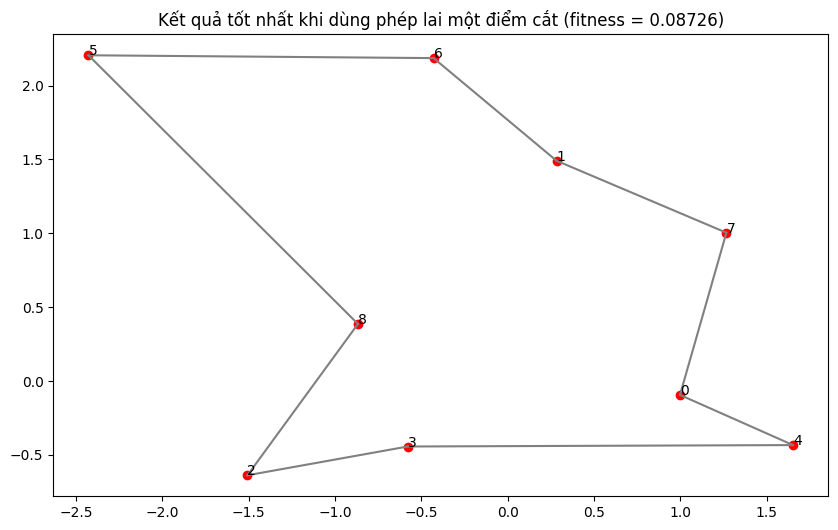

In [97]:
mapping(cities, singlePoint_pop[0][1], f"Kết quả tốt nhất khi dùng phép lai một điểm cắt (fitness = {round(1 / float(GA_with_singlePointCrossover[0][0]), 5)})")

In [34]:
GA_with_multiPointCrossover, multiPoint_time, multiPoint_pop, record_fitness = GA_with_MultiPointCrossover(cities)
GA_with_multiPointCrossover = np.array(sorted(map(tuple, GA_with_multiPointCrossover)))
print(multiPoint_time)
pd.DataFrame(data=GA_with_multiPointCrossover[:,0], index=GA_with_multiPointCrossover[:,1], columns = ['multiPointCrossover']).head()


0.66


,multiPointCrossover
map_0,11.46
map_1,11.46
map_10,11.46
map_11,11.46
map_12,11.46


In [ ]:
GA_with_cycleCrossover, cycle_time, cycle_pop, record_fitness_cycle = GA_with_CycleCrossover(cities)
GA_with_cycleCrossover = np.array(sorted(map(tuple, GA_with_cycleCrossover)))
print(cycle_time)
pd.DataFrame(data=GA_with_cycleCrossover[:, 0], index=GA_with_cycleCrossover[:, 1], columns=['cycleCrossover']).head()


In [40]:
GA_with_pmx, pmx_time, pmx_pop, record_fitness = GA_with_PMX(cities)
GA_with_pmx = np.array(sorted(map(tuple, GA_with_pmx)))
print(pmx_time)
pd.DataFrame(data=GA_with_pmx[:,0], index=GA_with_pmx[:,1], columns=['pmx']).head()


0.65


,pmx
map_0,11.46
map_13,11.46
map_15,11.46
map_18,11.46
map_20,11.46


**Data small (29 thành phố)**

In [36]:
cities2, distance_mat_2 = readData('/kaggle/input/traveling-salesman-problem/small.csv')
print(cities2)
#distance_mat_2

           x          y
0  -9.326265  13.902797
1  -8.233092  14.873970
2   3.272331   3.961212
3   1.175829  -0.699877
4  -7.685728  16.162204
5  -0.637752  -0.173636
6   4.194633   3.705915
7   5.412912   6.754886
8  -0.861755   0.283627
9  -7.800476  13.394037
10 -7.205137  14.168845
11  4.988170   6.069316
12  1.490732  -2.798589
13 -7.954510  14.596634
14  5.338589   5.029683
15  7.238143   6.069393
16  5.978736   6.495644
17 -7.192763  16.039727
18 -0.140069  -0.879536
19  0.737369  -0.255619
20  7.392365   5.890706
21 -1.253881   0.927462
22 -8.772709  15.468439
23  4.609100   6.743712
24  5.573806   4.201937
25 -9.198301  14.162483
26 -6.582701  12.876900
27  0.907105   0.002846
28 -1.428681   0.688223


In [37]:
GA_with_multiPointCrossover, multiPoint_time, multiPoint_pop, record_fitness = GA_with_MultiPointCrossover(cities2)
GA_with_multiPointCrossover = np.array(sorted(map(tuple, GA_with_multiPointCrossover)))
print(multiPoint_time)
pd.DataFrame(data=GA_with_multiPointCrossover[:,0], index=GA_with_multiPointCrossover[:,1], columns = ['multiPointCrossover']).head()


1.34


,multiPointCrossover
map_15,50.07
map_13,50.63
map_17,50.67
map_8,51.39
map_16,51.43


In [99]:
GA_with_singlePointCrossover, singlePoint_time, singlePoint_pop, record_fitness = GA_with_SinglePointCrossover(cities2)
GA_with_singlePointCrossover = np.array(sorted(map(tuple, GA_with_singlePointCrossover)))
print(singlePoint_time)
pd.DataFrame(data=GA_with_singlePointCrossover[:,0], index=GA_with_singlePointCrossover[:,1], columns = ['singlePointCrossover']).head()


1.71


,singlePointCrossover
map_3,52.28
map_27,53.9
map_14,54.26
map_1,64.36
map_21,66.77


In [41]:
GA_with_pmx, pmx_time, pmx_pop, record_fitness = GA_with_PMX(cities2)
GA_with_pmx = np.array(sorted(map(tuple, GA_with_pmx)))
print(pmx_time)
pd.DataFrame(data=GA_with_pmx[:,0], index=GA_with_pmx[:,1], columns=['pmx']).head()


1.21


,pmx
map_14,53.19
map_23,54.52
map_1,57.12
map_7,62.48
map_11,65.56


In [100]:
print(GA_with_singlePointCrossover)
#print(singlePoint_pop)

[['52.28' 'map_3']
 ['53.9' 'map_27']
 ['54.26' 'map_14']
 ['64.36' 'map_1']
 ['66.77' 'map_21']
 ['67.97' 'map_19']
 ['68.38' 'map_29']
 ['69.55' 'map_16']
 ['69.88' 'map_25']
 ['70.05' 'map_4']
 ['70.93' 'map_20']
 ['71.15' 'map_6']
 ['71.18' 'map_9']
 ['71.39' 'map_10']
 ['71.41' 'map_18']
 ['71.81' 'map_13']
 ['72.27' 'map_2']
 ['72.83' 'map_0']
 ['73.49' 'map_12']
 ['75.14' 'map_11']
 ['76.3' 'map_23']
 ['77.45' 'map_22']
 ['78.31' 'map_8']
 ['80.55' 'map_17']
 ['80.88' 'map_15']
 ['88.75' 'map_26']
 ['90.05' 'map_28']
 ['97.0' 'map_5']
 ['110.23' 'map_24']
 ['115.58' 'map_7']]


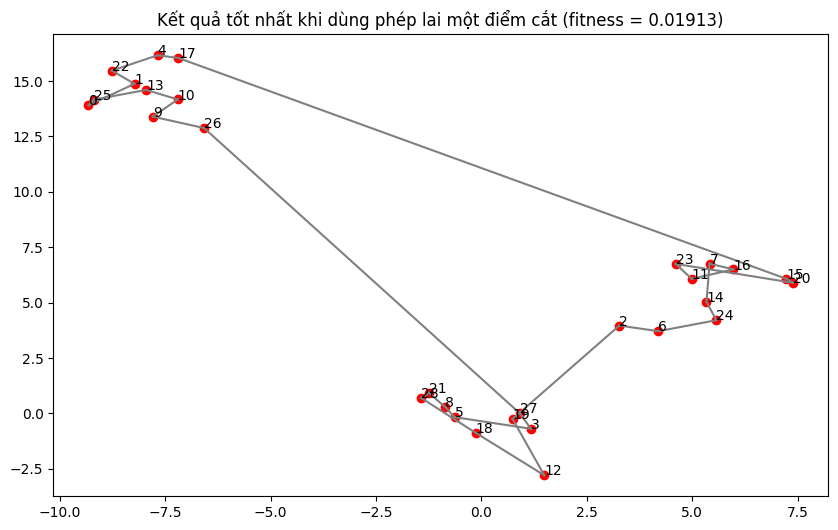

In [101]:
mapping(cities2, singlePoint_pop[0][1], f"Kết quả tốt nhất khi dùng phép lai một điểm cắt (fitness = {round(1 / float(GA_with_singlePointCrossover[0][0]), 5)})")

**2. Data medium (99 thành phố)**

In [38]:
cities3, distance_mat_3 = readData('/kaggle/input/traveling-salesman-problem/medium.csv')

In [103]:
print(cities3)

           x         y
0   0.058938  0.679530
1   0.478459  0.053815
2   0.521159  0.806604
3   0.580632  0.602950
4   0.309199  0.655213
..       ...       ...
94  0.493003  0.715257
95  0.979360  0.628281
96  0.323508  0.967511
97  0.189567  0.281418
98  0.305229  0.246395

[99 rows x 2 columns]


In [104]:
GA_with_singlePointCrossover, singlePoint_time, singlePoint_pop, record_fitness = GA_with_SinglePointCrossover(cities3)
GA_with_singlePointCrossover = np.array(sorted(map(tuple, GA_with_singlePointCrossover)))
print(singlePoint_time)

6.8


In [39]:
GA_with_multiPointCrossover, multiPoint_time, multiPoint_pop, record_fitness = GA_with_MultiPointCrossover(cities3)
GA_with_multiPointCrossover = np.array(sorted(map(tuple, GA_with_multiPointCrossover)))
print(multiPoint_time)
pd.DataFrame(data=GA_with_multiPointCrossover[:,0], index=GA_with_multiPointCrossover[:,1], columns = ['multiPointCrossover']).head()


5.64


,multiPointCrossover
map_0,13.45
map_22,13.48
map_28,13.61
map_27,13.77
map_15,13.88


In [49]:
GA_with_pmx, pmx_time, pmx_pop, record_fitness = GA_with_PMX(cities3)
GA_with_pmx = np.array(sorted(map(tuple, GA_with_pmx)))
print(pmx_time)
pd.DataFrame(data=GA_with_pmx[:,0], index=GA_with_pmx[:,1], columns=['pmx']).head()


3.95


,pmx
map_13,20.05
map_10,20.54
map_28,20.58
map_19,20.63
map_2,20.64


In [105]:
pd.DataFrame(data=GA_with_singlePointCrossover[:,0], index=GA_with_singlePointCrossover[:,1], columns = ['singlePointCrossover']).head()

,singlePointCrossover
map_24,18.86
map_21,19.36
map_9,19.51
map_16,19.6
map_18,19.62


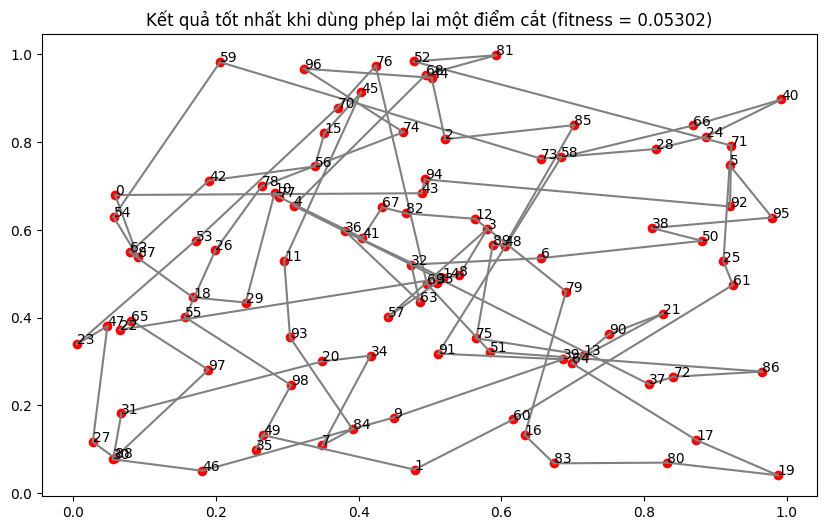

In [107]:
mapping(cities3, singlePoint_pop[0][1], f"Kết quả tốt nhất khi dùng phép lai một điểm cắt (fitness = {round(1 / float(GA_with_singlePointCrossover[0][0]), 5)})")

**Dữ liệu lớn (999 thành phố)**

In [108]:
cities4, distance_mat_4 = readData('/kaggle/input/traveling-salesman-problem/large.csv')
print(cities4)

            x         y
0    0.892075  0.737351
1    0.034545  0.418465
2    0.491475  0.643941
3    0.000905  0.633602
4    0.889199  0.074612
..        ...       ...
994  0.847369  0.338414
995  0.971654  0.900917
996  0.164339  0.870318
997  0.492553  0.679674
998  0.658919  0.458835

[999 rows x 2 columns]


In [ ]:
#distance_mat_4

In [ ]:
GA_with_singlePointCrossover, singlePoint_time, singlePoint_pop, record_fitness = GA_with_SinglePointCrossover(cities4)
GA_with_singlePointCrossover = np.array(sorted(map(tuple, GA_with_singlePointCrossover)))
print(singlePoint_time)
pd.DataFrame(data=GA_with_singlePointCrossover[:,0], index=GA_with_singlePointCrossover[:,1], columns = ['singlePointCrossover'])

In [ ]:
mapping(cities4, singlePoint_pop[0][1], f"Kết quả tốt nhất khi dùng phép lai một điểm cắt (fitness = {round(1 / float(GA_with_singlePointCrossover[0][0]), 5)})")